In [4]:
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
import random
import tensorflow as tf

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, Flatten, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.optimizers import RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator #, img_to_array

# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from keras import backend as K
from keras import regularizers#, callbacks
from random import randint
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
# from google.colab.patches import cv2_imshow



In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
def evaluate_model(test_images, test_labels, classes, dir_array):
    with open('face_recognition_model.pkl', 'rb') as f:
        model = pickle.load(f)

    score = model.evaluate(test_images, test_labels, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [9]:
path = 'C:\\Users\\saras\\Desktop\\c_yale_me_dataset\\CroppedYale\\CroppedYale_2\\'
    
a = np.array([i for i in range(38)])
classes = np.zeros((a.size, a.max() + 1))
classes[np.arange(a.size), a] = 1
train_array = []
test_array = []
dir_array = []

# let random index and 20th(enumerate begins at 0 so index 19 represents image 20) pgm for test
#image resolution 168x192
for dir in os.listdir(path):
    i1 = np.random.choice(range(0,65), 26)
    for i1, img in enumerate(sorted(os.listdir(path + dir))):
        image = cv2.imread(path + dir + '/' + img, 0)
        image = cv2.resize(image, (64, 64))
        image = image[:, :, np.newaxis]
        if i1:
          train_array.append((image, classes[os.listdir(path).index(dir)]))
        elif not(i1):
          test_array.append((image, classes[os.listdir(path).index(dir)]))
    dir_array.append(dir)
input_shape = (64, 64, 1) #168 X 192

In [10]:
model = Sequential()
# convolutional layer 16 windows/filters of 3x3
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.),
                 activity_regularizer=regularizers.l2(0.),
                 input_shape=input_shape))
# max of each 2x2 block
model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(MaxPooling2D(pool_size=(2, 2)))

# normalization
model.add(BatchNormalization())
# avoid overfitting
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(4,4),
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.),
                 activity_regularizer=regularizers.l2(0.)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(layers.GlobalMaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size=(5,5),
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.),
                 activity_regularizer=regularizers.l2(0.)))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.GlobalMaxPooling2D())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))

# flatten for final layers
model.add(Flatten())
# fully-connected layer
model.add(Dense(2048, activation='relu',
                kernel_regularizer=regularizers.l2(0.),
                activity_regularizer=regularizers.l2(0.)))
model.add(Dropout(0.25))
model.add(Dense(38, activation='softmax'))
model.summary()
#opt = SGD(learning_rate = 0.01, decay = 0.0002, momentum = 0.8, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 average_pooling2d (AverageP  (None, 31, 31, 32)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        32832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)      

In [11]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

In [ ]:
train_images, train_labels = np.array([t[0] for t in train_array]), np.array([t[1] for t in train_array])
test_images, test_labels = np.array([t[0] for t in test_array]), np.array([t[1] for t in test_array])
# history = model.fit(train_images, train_labels,
#                     batch_size=200,
#                     epochs=10,
#                     verbose=2,
#                     validation_data=(test_images, test_labels))
history = model.fit(x=train_images, y=train_labels,
                    steps_per_epoch=25,
                    epochs=100,
                    verbose=2,
                    validation_steps=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[early_stopping_callback])

# hist = model.fit_generator(steps_per_epoch=25,generator=(train_images,
#                            validation_data= (test_images, test_labels), validation_steps=10,epochs=100,callbacks=[early_stopping_callback])

Epoch 1/100
25/25 - 20s - loss: 4.4205 - accuracy: 0.1012 - val_loss: 12.6344 - val_accuracy: 0.0263 - 20s/epoch - 809ms/step
Epoch 2/100
25/25 - 17s - loss: 2.4063 - accuracy: 0.3757 - val_loss: 9.8534 - val_accuracy: 0.1053 - 17s/epoch - 680ms/step
Epoch 3/100
25/25 - 16s - loss: 1.3543 - accuracy: 0.6331 - val_loss: 4.5751 - val_accuracy: 0.1316 - 16s/epoch - 656ms/step
Epoch 4/100
25/25 - 19s - loss: 0.8514 - accuracy: 0.7587 - val_loss: 4.5818 - val_accuracy: 0.1579 - 19s/epoch - 751ms/step
Epoch 5/100
25/25 - 17s - loss: 0.5956 - accuracy: 0.8345 - val_loss: 2.7420 - val_accuracy: 0.2632 - 17s/epoch - 661ms/step
Epoch 6/100
25/25 - 16s - loss: 0.4468 - accuracy: 0.8749 - val_loss: 0.6467 - val_accuracy: 0.8947 - 16s/epoch - 652ms/step
Epoch 7/100
25/25 - 16s - loss: 0.3109 - accuracy: 0.9149 - val_loss: 0.4145 - val_accuracy: 1.0000 - 16s/epoch - 659ms/step
Epoch 8/100
25/25 - 17s - loss: 0.2522 - accuracy: 0.9273 - val_loss: 0.1997 - val_accuracy: 0.9737 - 17s/epoch - 669ms/step

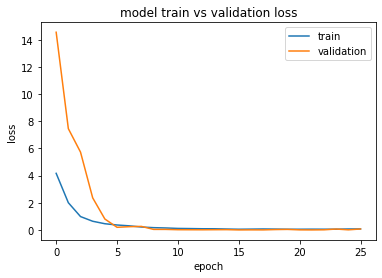

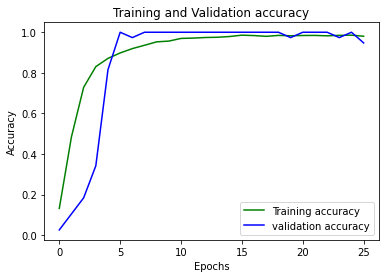

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = []
for x in range (0,len(loss_train)):
  epochs.append(x)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
with open('face_recognition_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
evaluate_model(test_images, test_labels, classes, dir_array)

Test loss: 0.0005655656568706036
Test accuracy: 1.0
